# Displaying North Atlantic Particles

## Light particle analysis
    - Particle trajectories are saved for 7 years: 
    - 1958: 306-312 (7 years)
    - 2012: 360-366 
    - This notebook analyzes the trajectory 6-year trajectory from tropical Atlantic

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import gsw
import scipy.interpolate as itp
import os
import cartopy.crs as ccrs

In [2]:
#! ls GMPAS-JRA1p4_EC30to60E2r2_chrys-bgc1-bk1.5e-5-hindcast-lightv1-seedB-2012
! rm -rf regional_trajectory

In [3]:
dirs=['/global/cfs/cdirs/m3920/dataset/E3SM-2G/run1/light',
     '/global/cfs/cdirs/m3920/dataset/E3SM-2G/GMPAS-JRA1p4_EC30to60E2r2_chrys-bgc1-bk1.5e-5-hindcast-lightv1-seedB-1958',\
     '/global/cfs/cdirs/m3920/dataset/E3SM-2G/GMPAS-JRA1p4_EC30to60E2r2_chrys-bgc1-bk1.5e-5-hindcast-lightv1-seedB-2012',\
     '/global/cfs/cdirs/m3920/dataset/E3SM-2G/GMPAS-JRA1p4_EC30to60E2r2_chrys-bgc1-hindcast-lightv1-seedB-1958',\
     '/global/cfs/cdirs/m3920/dataset/E3SM-2G/GMPAS-JRA1p4_EC30to60E2r2_chrys-bgc1-hindcast-lightv1-seedB-2012']
fn=['GMPAS-JRA1p4_EC30to60E2r2_anvil-bgc1-bk1.5e-5-hindcast-lightv1-seedB-1958.mpaso.hist.am.lagrPartTrack',\
    'GMPAS-JRA1p4_EC30to60E2r2_anvil-bgc1-hindcast-lightv1-seedB-1958.mpaso.hist.am.lagrPartTrack',\
    'GMPAS-JRA1p4_EC30to60E2r2_anvil-bgc1-hindcast-lightv1-seedB-1958.mpaso.hist.am.lagrPartTrack']
ffco2='run1/Omon/fgco2_Omon_E3SM-MPAS-O-2_JRA1p4_EC30to60E2r2_bgc1-hindcast_gwoa2013cp_195801-201812.nc'
ftheta='run1/Omon/thetao_Omon_E3SM-MPAS-O-2_JRA1p4_EC30to60E2r2_bgc1-hindcast_gwoa2013cpL33_195801-201812.nc'
frho='run1/Omon/rhopoto_Omon_E3SM-MPAS-O-2_JRA1p4_EC30to60E2r2_bgc1-hindcast_gwoa2013cp_195801-201812.nc'
frmb='run1/Omon/rho_at_MLbase_Mar.nc'
#

In [4]:
# define analysis domain
xb0=[285] # eastern longitude
yb0=[-10] # southern latitude
dxb=75   # longitudinal extent
dyb=30    # latitudinal extent
#
rname=['NA']
cb=['m','b','k','r']

### define some helper functions
select_particle_XYZT: This function identifies particle trajectory that passes (lon,lat,depth) position within (Rxy) lon-lat degree radius within the depth range of (Rz) at (refyear, refmon). It returns particle ID (partid) and indices (ind)

extract_trajectory_yearly(year): This function extracts (lon,lat,depth) position of certain particle with (ind) indices and save them as netCDF file for the model year (year)

In [5]:
# select particle
def select_particle_XYZT(lon,lat,dlon,dlat,zmin,zmax,refyear,refmon):
    scale = 180/np.pi
    if refyear > 2000:
        pyr = refyear - 2012 + 360
        pmo = ["%.2d" % refmon]
        nfile = dirs[2]+'/'+fn[1]+'.0'+str(pyr)+'-'+pmo[0]+'-01_00.00.00.nc'
    else:
        pyr = refyear - 1958 + 306
        pmo = ["%.2d" % refmon]
        nfile = dirs[1]+'/'+fn[0]+'.0'+str(pyr)+'-'+pmo[0]+'-01_00.00.00.nc'
    #
    print(nfile)
    ds=xr.open_dataset(nfile)
    xloc = ds['lonParticle'][0,:]*scale
    yloc = ds['latParticle'][0,:]*scale
    zloc = ds['zLevelParticle'][0,:]
    indxy = (xloc>lon)&(xloc<lon+dlon)&(yloc>lat)&(yloc<lat+dlat)
    partidxy=ds['indexToParticleID'][indxy]
    #
    N=np.size(indxy)
    ind=np.empty(N,dtype=bool)
    for n in range(N):
        if indxy[n]==True:
            zloc0=zloc[n].to_numpy()
            if (zloc0>zmin) & (zloc0<zmax):
                ind[n]=True
            else:
                ind[n]=False    
        else:
            ind[n]=False
    partid=ds['indexToParticleID'][ind]
    return partid,ind

In [52]:
# This identifies the particles that meets the criteria
partid,ind = select_particle_XYZT(xb0[0],yb0[0],dxb,dyb,-500,0,2012,1)

/global/cfs/cdirs/m3920/dataset/E3SM-2G/GMPAS-JRA1p4_EC30to60E2r2_chrys-bgc1-bk1.5e-5-hindcast-lightv1-seedB-2012/GMPAS-JRA1p4_EC30to60E2r2_anvil-bgc1-hindcast-lightv1-seedB-1958.mpaso.hist.am.lagrPartTrack.0360-01-01_00.00.00.nc


In [53]:
print(f'There are {np.sum(ind)} particles seeded in the domain')

There are 1700 particles seeded in the domain


In [8]:
# select MLD particle
def select_particle_MLD(lon,lat,mld,dlon,dlat,refyear,refmon):
    scale = 180/np.pi
    if refyear > 2000:
        pyr = refyear - 2012 + 360
        pmo = ["%.2d" % refmon]
        nfile = dirs[2]+'/'+fn[1]+'.0'+str(pyr)+'-'+pmo[0]+'-01_00.00.00.nc'
    else:
        pyr = refyear - 1958 + 306
        pmo = ["%.2d" % refmon]
        nfile = dirs[1]+'/'+fn[0]+'.0'+str(pyr)+'-'+pmo[0]+'-01_00.00.00.nc'
    #
    print(nfile)
    ds=xr.open_dataset(nfile)
    xloc = ds['lonParticle'][0,:]*scale
    yloc = ds['latParticle'][0,:]*scale
    zloc = ds['zLevelParticle'][0,:]
    indxy = (xloc>lon)&(xloc<lon+dlon)&(yloc>lat)&(yloc<lat+dlat)
    partidxy=ds['indexToParticleID'][indxy]
    #
    N=np.size(indxy)
    ind=np.empty(N,dtype=bool)
    for n in range(N):
        if indxy[n]==True:
            hloc=mld.sel(lon=xloc[n],method='nearest').sel(lat=yloc[n],method='nearest').to_numpy()
            hloc0=hloc*(-1)
            zloc0=zloc[n].to_numpy()
            if zloc0>hloc0:
                ind[n]=True
            else:
                ind[n]=False    
        else:
            ind[n]=False
    partid=ds['indexToParticleID'][ind]
    return partid,ind

In [9]:
def extract_trajectory(refyear,refmon,ind,tempdir):
    dmon=[31,29,31,30,31,30,31,31,30,31,30,31]
    scale = 180/np.pi
    if refyear > 2000:
        pyr = refyear - 2012 + 360
        pmo = ["%.2d" % refmon]
        nfile = dirs[2]+'/'+fn[1]+'.0'+str(pyr)+'-'+pmo[0]+'-01_00.00.00.nc'
    else:
        pyr = refyear - 1958 + 306
        pmo = ["%.2d" % refmon]
        nfile = dirs[1]+'/'+fn[0]+'.0'+str(pyr)+'-'+pmo[0]+'-01_00.00.00.nc'
    #
    #print(nfile)
    ds=xr.open_dataset(nfile) 
    dx = ds['lonParticle'].where(ind)*scale
    dy = ds['latParticle'].where(ind)*scale
    dz = ds['zLevelParticle'].where(ind)
    dT = ds['particleTemperature'].where(ind)
    dS = ds['particleSalinity'].where(ind)
    dC = ds['particleDIC'].where(ind)
    dO = ds['particleO2'].where(ind)
    dP = ds['particlePO4'].where(ind)
    dFe = ds['particleFe'].where(ind)
    x=dx.dropna(dim='nParticles')
    y=dy.dropna(dim='nParticles')
    z=dz.dropna(dim='nParticles')
    C=dC.dropna(dim='nParticles')
    O=dO.dropna(dim='nParticles')
    P=dP.dropna(dim='nParticles')
    Fe=dFe.dropna(dim='nParticles')
    T=dT.dropna(dim='nParticles')
    S=dS.dropna(dim='nParticles')
    Nt=np.size(ds.Time.to_numpy())
    ds=xr.merge([x,y,z,T,S,C,O,P,Fe])
    Np=np.size(ds.nParticles.to_numpy())
    t1=np.arange(0,Nt,1)+np.sum(dmon[:int(refmon-1)])+366*(pyr-360)
    ds['Time']=t1
    #
    # add local MLD
    dh=xr.open_dataset('/global/cfs/cdirs/m3920/dataset/E3SM-2G/MLD_Omon_E3SM-MPAS-O-2_JRA1p4_EC30to60E2r2_bgc1-hindcast_gwoa2013cpL33_195801-201812.nc')
    mldxy=dh.MLD.sel(time=str(refyear)+'-'+pmo[0])
    mld=np.zeros((Nt,Np))
    for n in range(Nt):
        for m in range(Np):
            xloc=x[n,m].to_numpy()
            yloc=y[n,m].to_numpy()
            hloc=mldxy.sel(lon=xloc,method='nearest').sel(lat=yloc,method='nearest').to_numpy()
            mld[n,m]=hloc*(-1)
    #print(mld)
    da=xr.DataArray(data=mld,name='MLD',dims=['Time','nParticles'],\
                    coords={'Time':ds.Time,'nParticles':ds.nParticles})
    #print(t1)    
    ds['MLD']=da
    ds.to_netcdf(tempdir+'/xyz-'+str(refyear)+'-'+str(refmon)+'.nc')

In [10]:
# Extract the trajectory data for one month 
! mkdir -p temp
extract_trajectory(2012,1,ind,'temp')

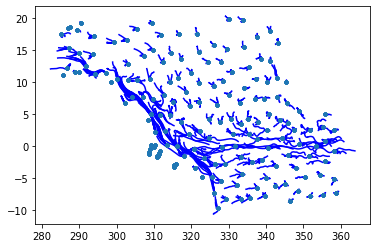

In [54]:
# display 1 month trajectory
ds=xr.open_dataset('temp/xyz-2012-1.nc')
x=ds.lonParticle.to_numpy()
y=ds.latParticle.to_numpy()
wrap=x<100
x[wrap]=x[wrap]+360
plt.plot(x,y,'-',color='b')
plt.plot(x[0,:],y[0,:],'.')
plt.show()

In [12]:
! rm temp/*
# Follow the same particles for multiple years
for n,yr in enumerate([2012,2013,2014,2015,2016,2017]):
    for m in range(12):
        extract_trajectory(yr,m+1,ind,'temp')

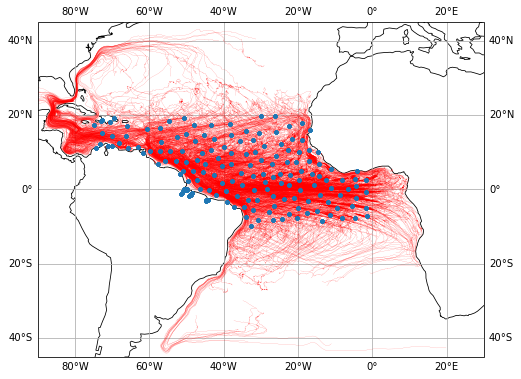

In [56]:
# then display them using cartopy
import cartopy
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
#
ds=xr.open_mfdataset('temp/xyz-*.nc')
x=ds.lonParticle.to_numpy()
y=ds.latParticle.to_numpy()
wrap=x<100
x[wrap]=x[wrap]+360
#
fig=plt.figure(figsize=(8,12),facecolor='w', edgecolor='k')
usemap_proj = ccrs.PlateCarree(central_longitude=0)
usemap_proj._threshold /= 20.  
ax = plt.axes(projection=usemap_proj)
ax.set_extent([270, 390, -45, 45], crs=ccrs.PlateCarree())
ax.plot(x,y,'-',color='r',linewidth=.1,transform=ccrs.PlateCarree())
ax.plot(x[0,:],y[0,:],'.',transform=ccrs.PlateCarree())
ax.coastlines(color='k', linewidth=.8)
ax.gridlines(draw_labels=True)
plt.show()

In [59]:
# Now look for particles that reached subtropical NA (north of 30N)
ymax=np.max(y,axis=0)
ind=(ymax>=30)
print(np.sum(ind))

46


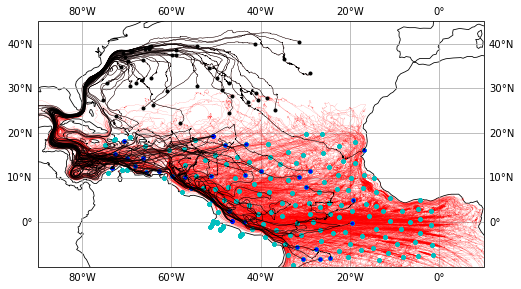

In [60]:
fig=plt.figure(figsize=(8,8),facecolor='w', edgecolor='k')
#
usemap_proj = ccrs.PlateCarree(central_longitude=0)
usemap_proj._threshold /= 20.  
#
# to make greatcircle smooth
ax = plt.axes(projection=usemap_proj)
ax.set_extent([270, 370, -10, 45], crs=ccrs.PlateCarree())
ax.plot(x,y,'-',color='r',linewidth=.1,transform=ccrs.PlateCarree())
ax.plot(x[0,:],y[0,:],'c.',transform=ccrs.PlateCarree())
ax.plot(x[-1,ind],y[-1,ind],'k.',transform=ccrs.PlateCarree())
ax.plot(x[0,ind],y[0,ind],'b.',transform=ccrs.PlateCarree())
ax.plot(x[:,ind],y[:,ind],'k-',linewidth=.5,transform=ccrs.PlateCarree())
ax.coastlines(color='k', linewidth=.8)
ax.gridlines(draw_labels=True)